In [1]:
# We train an agent to map states to action values

from unityagents import UnityEnvironment

import torch
import numpy as np
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import time
from dqn_agent import Agent     # import agent.py
import pandas as pd

WEIGHTS_PATH = 'outputs/'       # save weights here
WEIGHTS_FILE = 'outputs/checkpoint_solved1597951739.pth'          # use weights from trained agent


In [2]:
# instantiate environment, skip no graphics if you want to watch the agent in action
env = UnityEnvironment(file_name="unity_stuff/Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

env_info = env.reset(train_mode=False)[brain_name]  # reset the environment
state = env_info.vector_observations[0]  # get the current state
state_size = len(state)

agent = Agent(state_size, action_size, seed=0, duel=True)  # initialise agent

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1


In [3]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1, eps_end=0.01, eps_decay=0.993):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []             # track episode scores
    yellow_bananas = []     # track episode yellow bananas
    blue_bananas = []       # track episode blue bananas
    steps = []              # track episode steps
    epsilons = []           # track episode epsilons
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start  # initialize epsilon

    for i_episode in range(1, n_episodes + 1):

        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]  # get the current state
        score = 0  # initialize the score
        n_steps = 0  # initialize steps
        n_yellow_bananas = 0
        n_blue_bananas = 0

        while True:
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]  # send the action to the environment
            next_state = env_info.vector_observations[0]  # get the next state
            reward = env_info.rewards[0]  # get the reward
            done = env_info.local_done[0]  # see if episode has finished
            score += reward  # update the score
            n_steps += 1
            if reward == -1:
                n_blue_bananas += 1
            if reward == 1:
                n_yellow_bananas += 1
            agent.step(state, action, reward, next_state, done)
            state = next_state  # roll over the state to next time step
            if done:  # exit loop if episode finished
                break
        
        # append performance metrics to lists
        scores_window.append(score)
        scores.append(score)
        steps.append(n_steps)
        yellow_bananas.append(n_yellow_bananas)
        blue_bananas.append(n_blue_bananas)
        epsilons.append(eps)

        eps = max(eps_end, eps_decay * eps)  # decrease epsilon

        # track training episodes and save weight file checkpoints
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.4f}'.format(i_episode, np.mean(scores_window), eps))
            weights_file_name = WEIGHTS_PATH + 'checkpoint_episode_' + str(i_episode) + '.pth'
            torch.save(agent.qnetwork_local.state_dict(), weights_file_name)
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            # save trained model weights with a timestamp
            weights_file_name = WEIGHTS_PATH + 'checkpoint_solved' + str(int(round(time.time(), 0))) + '.pth'
            torch.save(agent.qnetwork_local.state_dict(), weights_file_name)
            break

    return scores, steps, yellow_bananas, blue_bananas, epsilons

In [ ]:
# train the agent
start_time = time.time()
scores, steps, yellow_bananas, blue_bananas, epsilons = dqn()
env.close()

Episode 100	Average Score: 0.76	Epsilon: 0.4954


## Analyse training process

In [8]:
# put observations in lists
columns = ['scores', 'steps', 'yellow_bananas', 'blue_bananas', 'epsilons']
data = [scores, steps, yellow_bananas, blue_bananas, epsilons]

# convert to dataframe
df = pd.DataFrame(dict(zip(columns, data)))

# calculate moving average
df['Yellow Bananas Moving Avg 10'] = df['yellow_bananas'].rolling(window=10).mean()
df['Blue Bananas Moving Avg 10'] = df['blue_bananas'].rolling(window=10).mean()
df.tail()

,scores,steps,yellow_bananas,blue_bananas,epsilons,Yellow Bananas Moving Avg 10,Blue Bananas Moving Avg 10
432,14.0,300,16,0,0.048092,15.1,0.2
433,13.0,300,13,0,0.047756,14.9,0.2
434,17.0,300,18,1,0.047421,14.8,0.3
435,17.0,300,18,1,0.047089,15.7,0.4
436,13.0,300,13,0,0.046760,15.3,0.4


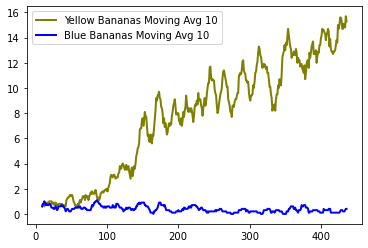

In [29]:
# Plot banana collection
plt.plot( 'Yellow Bananas Moving Avg 10', data=df, marker='', color='olive', linewidth=2)
plt.plot( 'Blue Bananas Moving Avg 10', data=df, marker='', color='blue', linewidth=2)
plt.legend()

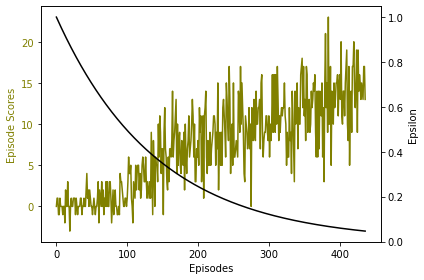

In [21]:
# Plot scores and epsilon
fig, ax1 = plt.subplots()

ax1.set_xlabel('Episodes')
ax1.set_ylabel('Episode Scores', color='olive')
ax1.plot(df['scores'], color='olive')
ax1.tick_params(axis='y', labelcolor='olive')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Epsilon', color='black')  # we already handled the x-label with ax1
ax2.plot(df['epsilons'], color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()